In [2]:
#IMPORTS INICIALES
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from autoencoderManager import AutoencoderManager
from fonts import getCharacterMatrix,getCharacterMap,getFormattedFont
from helpers.configHelper import ConfigHelper
from graph import plotErrorAgainstSteps
from noise import addNoise
import pickle
from os.path import exists


In [3]:
foo = ["A","B","C"]
bar = [1,2,3]

print(list(zip(foo,bar)))

[('A', 1), ('B', 2), ('C', 3)]


# TP5 - Deep Learning

In [4]:
#LEEMOS LOS PARAMETROS DEL CONFIG HELPER

configPath="./config/config.json"
configHelper = ConfigHelper(configPath)
(architecture,encoderActivationFunction,latentSpaceActivationFunction,decoderActivationFunction,encoderBeta,latentSpaceBeta,decoderBeta,learningRate,maxEpochs,maxToleranceExponent,randomSeed,font,noiseProbability) = configHelper.getProperties()

 'noise_probability' is a required parameter


## Ejercicio 1
### a) Autoencoder basico

In [5]:
#PEDIR LA FONT A UTILIZAR Y ARMAR EL TRAINING SET Y RESULT SET
(trainingSet,fontCharacters) = getFormattedFont(font,flatten=True)
resultsSet = trainingSet

In [6]:
# #Seteo de seed
# np.random.seed(randomSeed)
# random.seed(randomSeed)
# neuralNetworkManager = NeuralNetworkManager(architecture,activationFunction,learningRate,maxEpochs,maxToleranceExponent)
# (epochs,executionTime,exception) = neuralNetworkManager.start(trainingSet,resultsSet)

# #autoencoderManager = AutoencoderManager(architecture,activationFunction,learningRate,maxEpochs,errorHelper)
# #(epochs,executionTime,exception) = autoencoderManager.start(trainingSet,resultsSet)

# #Plot error graph
# plotEpochsError(epochs)
# #Print output
# print("FINISH-------------------------------------------------------------------------------------------")
# output = Output(configHelper,epochs[-1].error,epochs[-1].epochNumber,executionTime)
# output.printOutput()

In [7]:
# ENTRENAMIENTO DE LA RED
PATH = "autoencoderW.pickle"
autoencoderManager = AutoencoderManager(architecture,encoderActivationFunction,latentSpaceActivationFunction,decoderActivationFunction,learningRate,maxEpochs)
if exists(PATH):
    print("INITIALIZING WEIGHTS FOR CONFIGURATION")
    file = open(PATH,'rb')
    wFinal = pickle.load(file)
    file.close()
    autoencoderManager.initilizeWeights(trainingSet,wFinal)
else:
    print("CREATING WEIGHTS FOR CONFIGURATION")
    (wFinal,finalError) = autoencoderManager.start(trainingSet)
    file = open(PATH,'wb')
    pickle.dump(wFinal,file)
    file.close()

print(wFinal)
    


INITIALIZING WEIGHTS FOR CONFIGURATION
[-8.08131077 -1.11805568  0.27119615 ...  7.66730025 36.63859286
  6.49229312]


{'X': [0.9999999999956712, 1.0, 0.9118482017603725, 8.288263435159365e-08, 1.0, 3.512110113281818e-10], 'Y': [0.0019337058913438023, 0.9348495481662613, 1.446395501811151e-56, 0.9997033972836877, 8.092227508728705e-177, 0.9928410508592055], 'Label': ['@', 'A', 'B', 'C', 'D', 'E']}


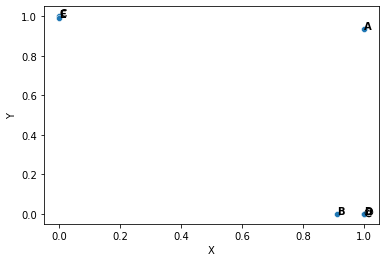

In [8]:
# LATENT SPACE CONFIGURATION
latentSpaceData = {
    'X' : [],
    'Y' : [],
    'Label':[]
}
i=0
for character in trainingSet:
    point = autoencoderManager.getLatentSpaceConfig(character)
    latentSpaceData['X'].append(point[0])
    latentSpaceData['Y'].append(point[1])
    latentSpaceData['Label'].append(fontCharacters[i])
    i+=1
data = pd.DataFrame(latentSpaceData)
print(latentSpaceData)
sp = sns.scatterplot(x="X",y="Y",data=data)
for c in range(0,data.shape[0]):
    sp.text(data.iloc[c]['X'],data.iloc[c]['Y'],data.iloc[c]['Label'],fontsize=10,horizontalalignment='left',weight='bold')

In [9]:
#GRAFICAR ERROR VS STEPS
plotErrorAgainstSteps(autoencoderManager.errors,autoencoderManager.steps)
print(autoencoderManager.steps)

AttributeError: 'AutoencoderManager' object has no attribute 'errors'

In [ ]:
# PLOT INPUT VS OUTPUT OF FINAL LAYER
figure, axes = plt.subplots( 2,len(formattedFont), sharex=True, figsize=(19,7))
for font in range(0,len(formattedFont)):
    getCharacterMap(formattedFont[font],ax=axes[0,font])
    umbralFormattedCharacter = [x if x>=0.35 else 0 for x in autoencoderManager.propagate(trainingSet[font])]
    getCharacterMap(getCharacterMatrix(np.array(umbralFormattedCharacter)),ax=axes[1,font])

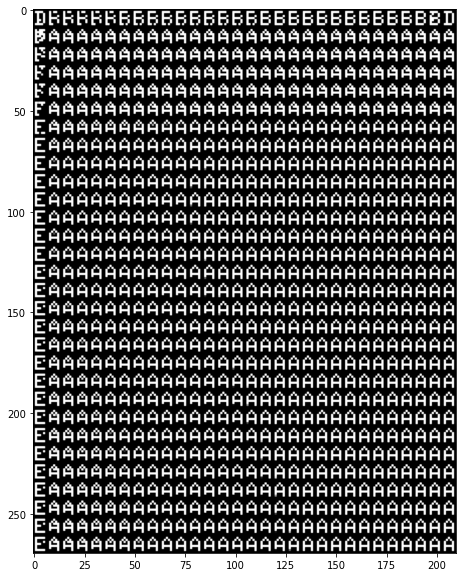

In [29]:
n = 30  # figure with 15x15 digits
width_digit_size = 5
height_digit_size = 7
figure = np.zeros(((height_digit_size+2) * n, (width_digit_size+2) * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = np.linspace(0, 1, n)
grid_y = np.linspace(0, 1, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = autoencoderManager.decodeFromLatentSpace(z_sample)
        digit = x_decoded.reshape(height_digit_size, width_digit_size)
        #digit = np.vectorize(lambda x: 0 if x==1  else 1 )(digit)
        #getCharacterMap(digit)
        x1 = i * (height_digit_size+2)+1
        x2 = ((i + 1) * (height_digit_size+2))-1
        y1 = (j * (width_digit_size+2))+1
        y2 = ((j + 1) * (width_digit_size+2))-1
        figure[x1: x2,
               y1: y2] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

### b) Denoising autoencoder

In [ ]:
#ARMAMOS TRAINING SET CON RUIDO Y EL NUEVO RESULTS SET

#Seteo de seed
np.random.seed(randomSeed)
random.seed(randomSeed)

numberOfElements = 5
#Agarramos las 10 primeras letras de la font
flattenedSubFont = getFormattedFont(font,flatten=True)[:numberOfElements]
# noiseProbability = 0.1
numberOfSubFonts = 5
#Armamos el trainingSet colocando las letras con distinto ruido segun la probabilidad especificada, y el resultsSet con las letras sin ruido
newTrainingSet = []
newResultsSet = []
# for i in range(0,numberOfSubFonts):
#     for j in range(0,len(flattenedSubFont)):
#         newTrainingSet.append(addNoise(flattenedSubFont[j],noiseProbability))
#         newResultsSet.append(flattenedSubFont[j])
for j in range(0,len(flattenedSubFont)):
    for i in range(0,numberOfSubFonts):
        newTrainingSet.append(addNoise(flattenedSubFont[j],noiseProbability))
        newResultsSet.append(flattenedSubFont[j])


newTrainingSet = np.asarray(newTrainingSet)
newResultsSet = np.asarray(newResultsSet)


In [ ]:
# IMPRIMIMOS EL TRAINING SET Y EL RESULTS SET
figure, axes = plt.subplots( 2,len(newTrainingSet), sharex=True, figsize=(19,7))
for i in range(0,len(newTrainingSet)):
    # print(newTrainingSet[i])
    umbralTrainingFormattedCharacter = [x if x>=0.35 else 0 for x in newTrainingSet[i]]
    getCharacterMap(getCharacterMatrix(np.array(umbralTrainingFormattedCharacter)),ax=axes[0,i])
    umbralResultFormattedCharacter = [x if x>=0.35 else 0 for x in newResultsSet[i]]
    getCharacterMap(getCharacterMatrix(np.array(umbralResultFormattedCharacter)),ax=axes[1,i])

    # getCharacterMap(formattedFont[font],ax=axes[0,font])
    # umbralFormattedCharacter = [x if x>=0.35 else 0 for x in autoencoderManager.propagate(trainingSet[font])]
    # getCharacterMap(getCharacterMatrix(np.array(umbralFormattedCharacter)),ax=axes[1,font])

In [ ]:
#ENTRENAMIENTO DE LA RED

denoisingAutoencoderManager = AutoencoderManager(architecture,encoderActivationFunction,latentSpaceActivationFunction,decoderActivationFunction,learningRate,maxEpochs)
(wFinal,finalError) = denoisingAutoencoderManager.start(newTrainingSet,newResultsSet)

In [ ]:
#TESTEO DE LA RED
#Generamos un nuevo set de letras con ruido
noiseSet = []
resultsSet = flattenedSubFont
for j in range(0,len(flattenedSubFont)):
        noiseSet.append(addNoise(flattenedSubFont[j],noiseProbability))
noiseSet = np.asarray(noiseSet)
#Comparamos el input ruidoso con la salida de la red
figure, axes = plt.subplots( 2,len(noiseSet), sharex=True, figsize=(19,7))
for i in range(0,len(noiseSet)):
    umbralTrainingFormattedCharacter = [x if x>=0.35 else 0 for x in noiseSet[i]]
    getCharacterMap(getCharacterMatrix(np.array(umbralTrainingFormattedCharacter)),ax=axes[0,i])
#     umbralResultFormattedCharacter = [x if x>=0.35 else 0 for x in newResultsSet[i]]
#     getCharacterMap(getCharacterMatrix(np.array(umbralResultFormattedCharacter)),ax=axes[1,i])
#     getCharacterMap(formattedFont[font],ax=axes[0,font])
    umbralResultFormattedCharacter = [x if x>=0.35 else 0 for x in denoisingAutoencoderManager.propagate(noiseSet[i])]
    getCharacterMap(getCharacterMatrix(np.array(umbralResultFormattedCharacter)),ax=axes[1,i])